# Intro

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
prob = .5

dropout = nn.Dropout(p = prob)
dropout

Dropout(p=0.5, inplace=False)

In [ ]:
x = torch.ones(10)
x

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [ ]:
y = dropout(x)
y

tensor([0., 2., 0., 2., 0., 2., 0., 2., 0., 0.])

In [ ]:
torch.mean(x)

tensor(1.)

In [ ]:
torch.mean(y)

tensor(0.8000)

In [ ]:
# droput is turned off when evaluating the model
dropout.eval()
y = dropout(x)
print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [ ]:
# F.dropout() is not deactivated in eval mode

dropout.eval()
y = F.dropout(x)
print(y)
print(torch.mean(y))

tensor([0., 2., 0., 2., 2., 2., 2., 2., 0., 0.])
tensor(1.2000)


In [ ]:
# we can manually switch it off
dropout.eval()
y = F.dropout(x, training = False)

print(y)
print(torch.mean(y))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor(1.)


In [ ]:
# model needs to be reset after toggling into eval mode
dropout.train()
y = dropout(x)
print(y)

dropout.eval()
y = dropout(x)
print(y)

dropout.train()
y = dropout(x)
print(y)

tensor([2., 0., 0., 2., 0., 0., 2., 2., 2., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
tensor([0., 0., 0., 0., 0., 0., 0., 2., 0., 0.])


# Dropout on Custom Data

In [ ]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

## Generate Data

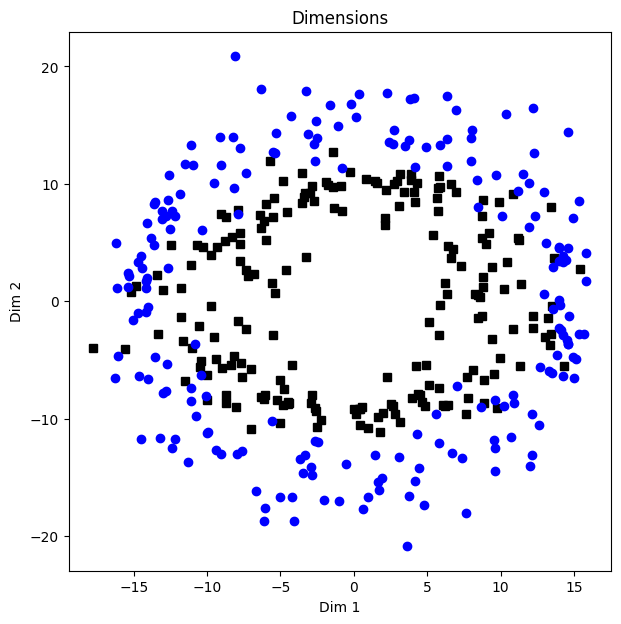

In [ ]:
n_per_clust = 200
th = np.linspace(0, 4*np.pi,n_per_clust)
r1 = 10
r2 = 15

a = [r1 * np.cos(th) + np.random.randn(n_per_clust) * 3,
     r1 * np.sin(th) + np.random.randn(n_per_clust)]
b = [r2 * np.cos(th) + np.random.randn(n_per_clust),
     r2 * np.sin(th) + np.random.randn(n_per_clust)* 3]

labels_np = np.vstack((np.zeros((n_per_clust, 1)), np.ones((n_per_clust, 1))))
data_np = np.hstack((a,b)).T

labels = torch.tensor(labels_np).float()
data = torch.tensor(data_np).float()

plt.figure(figsize = (7,7))
plt.plot(data[np.where(labels == 0)[0],0], data[np.where(labels == 0)[0],1], 'ks', label='Black')
plt.plot(data[np.where(labels == 1)[0],0], data[np.where(labels == 1)[0],1], 'bo', label='Blue')
plt.title('Dimensions')
plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.show()

## Dataset and DataLoader

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataldr = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataldr = DataLoader(test_dataset, X_test.shape[0])

## Model Architecture

In [ ]:
class ModelArch(nn.Module):
  def __init__(self, dropout_rate):
    super().__init__()

    self.input = nn.Linear(2, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 1)

    self.dr = dropout_rate
  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = F.dropout(x, p = self.dr, training = self.training)

    x = self.hidden(x)
    x = F.relu(x)
    x = F.dropout(x, p = self.dr, training = self.training)

    x = self.output(x)

    return x

Test

In [ ]:
temp_model = ModelArch(.25)
temp_data = torch.randn(10,2)
temp_y_hat = temp_model(temp_data)
temp_y_hat, torch.argmax(temp_y_hat)

(tensor([[ 0.0444],
         [ 0.1953],
         [ 0.0785],
         [-0.0104],
         [ 0.1258],
         [ 0.1441],
         [ 0.1542],
         [ 0.0082],
         [-0.0998],
         [ 0.0443]], grad_fn=<AddmmBackward0>),
 tensor(1))

## Model

In [ ]:
def model(dropout_rate):
  ann = ModelArch(dropout_rate)
  loss_fn = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3)

  return ann, loss_fn, optimizer

## Train

In [ ]:
def train(dropout_rate):
  ann, loss_fn, optimizer = model(dropout_rate)
  num_epochs = 1000

  train_losses = torch.zeros(num_epochs)
  test_losses = torch.zeros(num_epochs)

  train_accs = torch.zeros(num_epochs)
  test_accs = torch.zeros(num_epochs)

  for epoch in range(num_epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataldr))

    for batch, (X_train, y_train) in enumerate(train_dataldr):
      train_y_hat = ann(X_train)
      train_loss = loss_fn(train_y_hat, y_train)
      batch_losses[batch] = train_loss

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

    train_losses[epoch] = torch.mean(batch_losses)

    train_acc = 100*torch.mean(((train_y_hat>0)==y_train).float()).item()
    train_accs[epoch] = train_acc

    ann.eval()

    X_test, y_test = next(iter(test_dataldr))
    test_y_hat = ann(X_test)
    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss

    test_acc = 100 * torch.mean(
        (torch.argmax(test_y_hat,axis=1) == y_test).float()
    )
    test_acc = 100*torch.mean(((test_y_hat>0)==y_test).float()).item()
    test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Epoch: {epoch}, Train Loss: {train_loss:2f}, Test Loss: {test_loss:2f}, Train Acc: {train_acc:2f}, Test Acc: {test_acc:2f}')

  return train_losses, test_losses, train_accs, test_accs

In [ ]:
train_losses, test_losses, train_accs, test_accs = train(0.25)

Epoch: 0, Train Loss: 0.785360, Test Loss: 0.739372, Train Acc: 50.000000, Test Acc: 47.499999
Epoch: 10, Train Loss: 0.640520, Test Loss: 0.690702, Train Acc: 68.750000, Test Acc: 48.750001
Epoch: 20, Train Loss: 0.731895, Test Loss: 0.688316, Train Acc: 59.375000, Test Acc: 48.750001
Epoch: 30, Train Loss: 0.851510, Test Loss: 0.686315, Train Acc: 37.500000, Test Acc: 48.750001
Epoch: 40, Train Loss: 0.789223, Test Loss: 0.684397, Train Acc: 34.375000, Test Acc: 48.750001
Epoch: 50, Train Loss: 0.691884, Test Loss: 0.682569, Train Acc: 50.000000, Test Acc: 48.750001
Epoch: 60, Train Loss: 0.733472, Test Loss: 0.680789, Train Acc: 56.250000, Test Acc: 48.750001
Epoch: 70, Train Loss: 0.694087, Test Loss: 0.677745, Train Acc: 50.000000, Test Acc: 48.750001
Epoch: 80, Train Loss: 0.661383, Test Loss: 0.675739, Train Acc: 50.000000, Test Acc: 48.750001
Epoch: 90, Train Loss: 0.810979, Test Loss: 0.673825, Train Acc: 43.750000, Test Acc: 48.750001
Epoch: 100, Train Loss: 0.664940, Test Lo

In [ ]:
def smooth(x, k = 5):
  return np.convolve(x, np.ones(k)/k, mode = 'same')

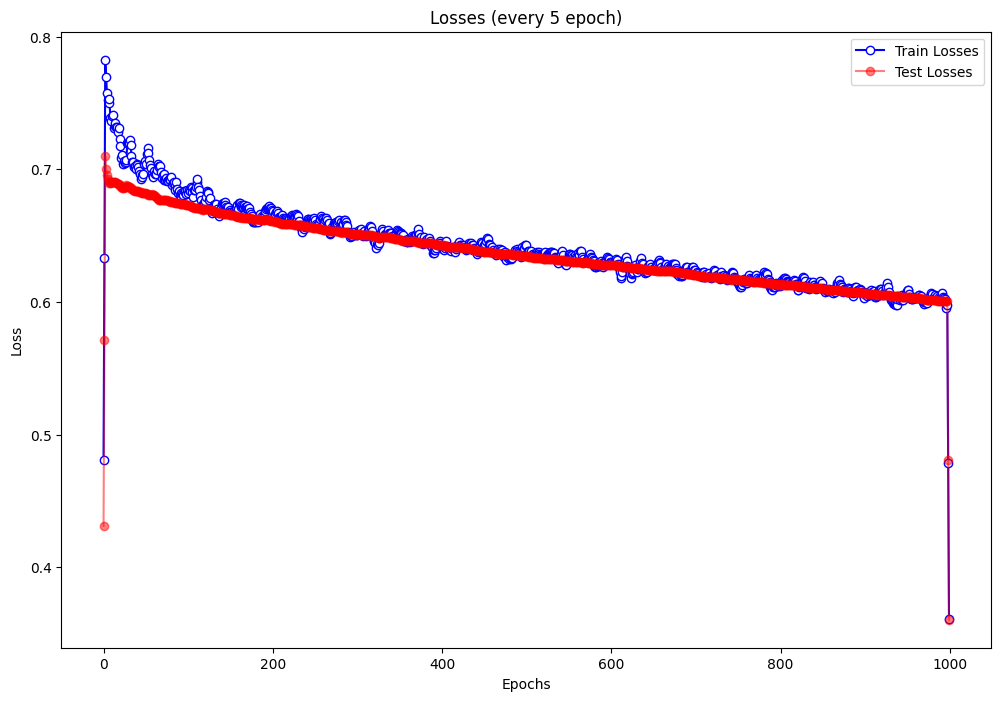

In [ ]:
r = 5
plt.figure(figsize = (12, 8))
plt.plot(smooth(train_losses.detach()), 'bo-', markerfacecolor='w')
plt.plot(smooth(test_losses.detach()), 'ro-', alpha=0.5)
plt.legend(['Train Losses', 'Test Losses'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title(f'Losses (every {r} epoch)')
plt.show()

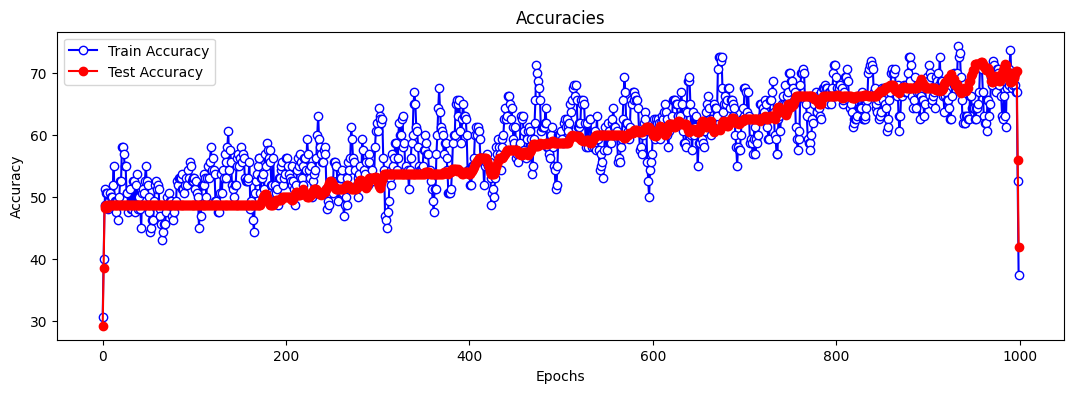

In [ ]:
plt.figure(figsize = (13, 4))
plt.plot(smooth(train_accs.detach()), 'bo-', markerfacecolor='w')
plt.plot(smooth(test_accs.detach()), 'ro-')
plt.title('Accuracies')
plt.legend(['Train Accuracy', 'Test Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Experiment

In [ ]:
dropout_rates = np.arange(20)/20
result_accs = np.zeros((len(dropout_rates), 2))


for di in range(len(dropout_rates)):
  print(f'\n\nPROCESSING dropout_rate: {dropout_rates[di]}')
  _, _, train_accs, test_accs = train(dropout_rates[di])

  # last 100 accuracies
  result_accs[di, 0] = torch.mean(train_accs[-100:])
  result_accs[di, 1] = torch.mean(test_accs[-100:])



PROCESSING dropout_rate: 0.0
Epoch: 0, Train Loss: 0.757059, Test Loss: 0.841935, Train Acc: 50.000000, Test Acc: 48.750001
Epoch: 10, Train Loss: 0.703459, Test Loss: 0.694380, Train Acc: 46.875000, Test Acc: 48.750001
Epoch: 20, Train Loss: 0.657448, Test Loss: 0.690491, Train Acc: 53.125000, Test Acc: 48.750001
Epoch: 30, Train Loss: 0.732215, Test Loss: 0.688319, Train Acc: 37.500000, Test Acc: 48.750001
Epoch: 40, Train Loss: 0.629825, Test Loss: 0.686715, Train Acc: 59.375000, Test Acc: 48.750001
Epoch: 50, Train Loss: 0.674970, Test Loss: 0.684448, Train Acc: 46.875000, Test Acc: 48.750001
Epoch: 60, Train Loss: 0.652710, Test Loss: 0.682628, Train Acc: 46.875000, Test Acc: 48.750001
Epoch: 70, Train Loss: 0.661591, Test Loss: 0.680989, Train Acc: 46.875000, Test Acc: 48.750001
Epoch: 80, Train Loss: 0.647745, Test Loss: 0.679358, Train Acc: 53.125000, Test Acc: 48.750001
Epoch: 90, Train Loss: 0.701558, Test Loss: 0.677174, Train Acc: 31.250000, Test Acc: 48.750001
Epoch: 100

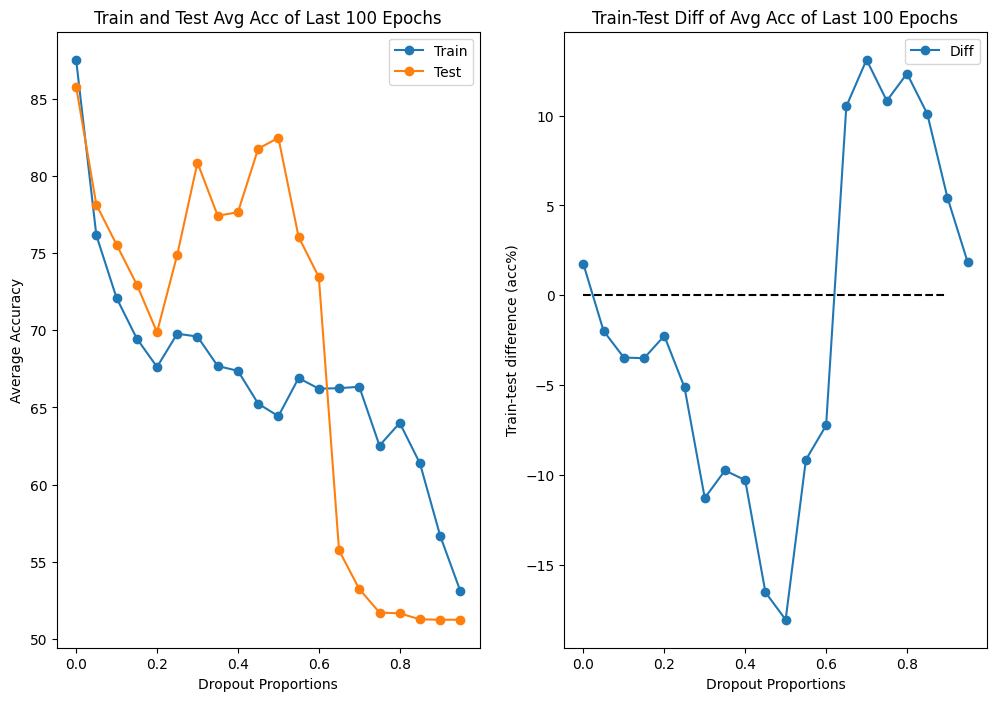

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))

ax[0].plot(dropout_rates, result_accs, 'o-')
ax[0].set_xlabel('Dropout Proportions')
ax[0].set_ylabel('Average Accuracy')
ax[0].legend(['Train', 'Test'])
ax[0].set_title('Train and Test Avg Acc of Last 100 Epochs')

ax[1].plot(dropout_rates, -np.diff(result_accs, axis=1), 'o-')
ax[1].plot([0,.9], [0,0], 'k--')
ax[1].set_xlabel('Dropout Proportions')
ax[1].set_ylabel('Train-test difference (acc%)')
ax[1].set_title('Train-Test Diff of Avg Acc of Last 100 Epochs')
ax[1].legend(['Diff'])

plt.show()

We can see that Accuracy is highest with 0.0 dropout and Overtraining actually occurs with higher dropout than 0.6. For this data we would like to don't use dropout at all.

# Dropout on Iris Data

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn import datasets

## Data

In [ ]:
iris_ = datasets.load_iris()
iris_

iris = torch.tensor(iris_['data']).float()
labels = torch.tensor(iris_['target'], dtype=torch.long)

iris[:10], labels[:10]

(tensor([[5.1000, 3.5000, 1.4000, 0.2000],
         [4.9000, 3.0000, 1.4000, 0.2000],
         [4.7000, 3.2000, 1.3000, 0.2000],
         [4.6000, 3.1000, 1.5000, 0.2000],
         [5.0000, 3.6000, 1.4000, 0.2000],
         [5.4000, 3.9000, 1.7000, 0.4000],
         [4.6000, 3.4000, 1.4000, 0.3000],
         [5.0000, 3.4000, 1.5000, 0.2000],
         [4.4000, 2.9000, 1.4000, 0.2000],
         [4.9000, 3.1000, 1.5000, 0.1000]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(iris, labels, train_size = .8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_dataldr = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataldr = DataLoader(test_dataset, batch_size = X_test.shape[0])

## Model Architecture

In [ ]:
class ModelArch(nn.Module):
  def __init__(self, dropout_rate):
    super().__init__()

    self.input = nn.Linear(4, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 3)

    self.dr = dropout_rate

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)
    x = F.dropout(x, p = self.dr, training = self.training)

    x = self.hidden(x)
    x = F.relu(x)
    x = F.dropout(x, p = self.dr, training = self.training)

    x = self.output(x)

    return x

## Model Setup

In [ ]:
def ModelSetup(dropout_rate):
  ann = ModelArch(dropout_rate)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 5e-3)

  return ann, loss_fn, optimizer

## Train

In [ ]:
def train(dropout_rate):
  ann, loss_fn, optimizer = ModelSetup(dropout_rate)
  epochs = 500

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataldr))
    batch_accs = torch.zeros(len(train_dataldr))

    for batch, (X_train, y_train) in enumerate(train_dataldr):
        train_y_hat = ann(X_train)
        train_loss = loss_fn(train_y_hat, y_train)
        train_acc = 100 * torch.mean(
            (torch.argmax(train_y_hat, axis = 1) == y_train).float()
        )

        batch_losses[batch] = train_loss
        batch_accs[batch] = train_acc

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

    train_losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    ann.eval()

    X_test, y_test = next(iter(test_dataldr))
    test_y_hat = ann(X_test)
    test_loss = loss_fn(test_y_hat, y_test)
    test_acc = 100 * torch.mean(
        (torch.argmax(test_y_hat, axis = 1) == y_test).float()
    )
    test_losses[epoch] = test_loss
    test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Epoch: {epoch}, Train Loss: {train_loss:2f}, Train Acc: {train_acc:2f}, Test Loss: {test_loss:2f}, Test Acc: {test_acc:2f}')

  return train_losses, test_losses, train_accs, test_accs

In [ ]:
train_losses, test_losses, train_accs, test_accs = train(0.25)

Epoch: 0, Train Loss: 1.141733, Train Acc: 29.166666, Test Loss: 1.044997, Test Acc: 36.666668
Epoch: 10, Train Loss: 0.952855, Train Acc: 45.833336, Test Loss: 0.792085, Test Acc: 66.666672
Epoch: 20, Train Loss: 0.698715, Train Acc: 83.333328, Test Loss: 0.660366, Test Acc: 70.000000
Epoch: 30, Train Loss: 0.704361, Train Acc: 70.833328, Test Loss: 0.581050, Test Acc: 86.666664
Epoch: 40, Train Loss: 0.524855, Train Acc: 87.500000, Test Loss: 0.529109, Test Acc: 80.000000
Epoch: 50, Train Loss: 0.528709, Train Acc: 70.833328, Test Loss: 0.491391, Test Acc: 90.000000
Epoch: 60, Train Loss: 0.521638, Train Acc: 79.166672, Test Loss: 0.464562, Test Acc: 93.333336
Epoch: 70, Train Loss: 0.532970, Train Acc: 75.000000, Test Loss: 0.440833, Test Acc: 93.333336
Epoch: 80, Train Loss: 0.419045, Train Acc: 79.166672, Test Loss: 0.423618, Test Acc: 93.333336
Epoch: 90, Train Loss: 0.382093, Train Acc: 79.166672, Test Loss: 0.407301, Test Acc: 90.000000
Epoch: 100, Train Loss: 0.470813, Train A

## Plot

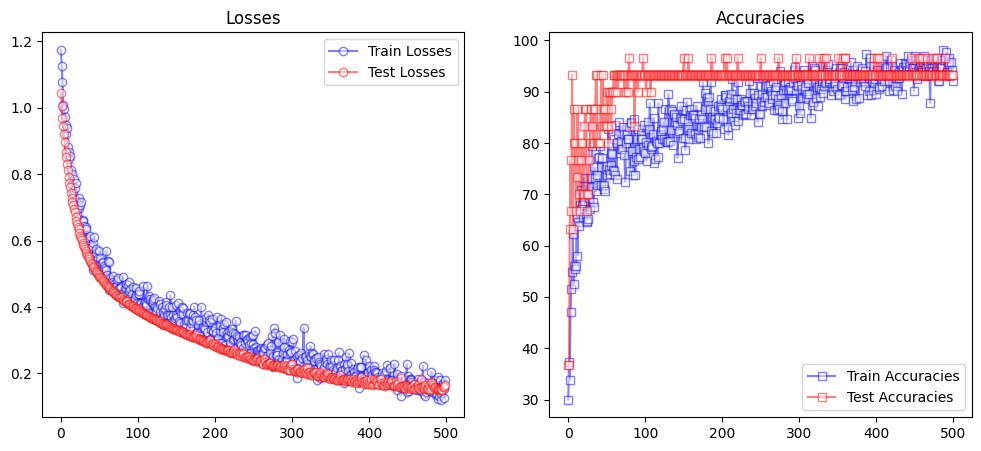

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ax[0].plot(train_losses.detach(), 'bo-', markerfacecolor='w', alpha=0.5, label= 'Train Losses')
ax[0].plot(test_losses.detach(), 'ro-', markerfacecolor='w', alpha=0.5, label = 'Test Losses')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(train_accs.detach(), 'bs-', markerfacecolor='w', alpha=.5, label = 'Train Accuracies')
ax[1].plot(test_accs.detach(), 'rs-', markerfacecolor='w', alpha=.5, label = 'Test Accuracies')
ax[1].set_title('Accuracies')
ax[1].legend()

plt.show()

## Experiment

In [ ]:
dropouts = np.linspace(0,20)/20
exp_accs = torch.zeros(len(dropouts), 2)

for dr in range(len(dropouts)):
  print(f'\n\nPROCESSING DROPOUT: {dropouts[dr]}')
  train_losses, test_losses, train_accs, test_accs = train(dropouts[dr])

  exp_accs[dr, 0] = torch.mean(train_accs)
  exp_accs[dr, 1] = torch.mean(test_accs)



PROCESSING DROPOUT: 0.0
Epoch: 0, Train Loss: 0.999950, Train Acc: 79.166672, Test Loss: 1.070643, Test Acc: 63.333332
Epoch: 10, Train Loss: 0.937386, Train Acc: 45.833336, Test Loss: 0.844965, Test Acc: 66.666672
Epoch: 20, Train Loss: 0.708929, Train Acc: 62.500000, Test Loss: 0.719327, Test Acc: 66.666672
Epoch: 30, Train Loss: 0.543070, Train Acc: 83.333328, Test Loss: 0.624063, Test Acc: 66.666672
Epoch: 40, Train Loss: 0.618091, Train Acc: 58.333332, Test Loss: 0.558911, Test Acc: 93.333336
Epoch: 50, Train Loss: 0.359584, Train Acc: 91.666672, Test Loss: 0.511093, Test Acc: 83.333328
Epoch: 60, Train Loss: 0.437351, Train Acc: 91.666672, Test Loss: 0.473928, Test Acc: 90.000000
Epoch: 70, Train Loss: 0.401242, Train Acc: 95.833328, Test Loss: 0.444086, Test Acc: 90.000000
Epoch: 80, Train Loss: 0.425080, Train Acc: 91.666672, Test Loss: 0.416768, Test Acc: 93.333336
Epoch: 90, Train Loss: 0.257723, Train Acc: 100.000000, Test Loss: 0.393186, Test Acc: 93.333336
Epoch: 100, Tr

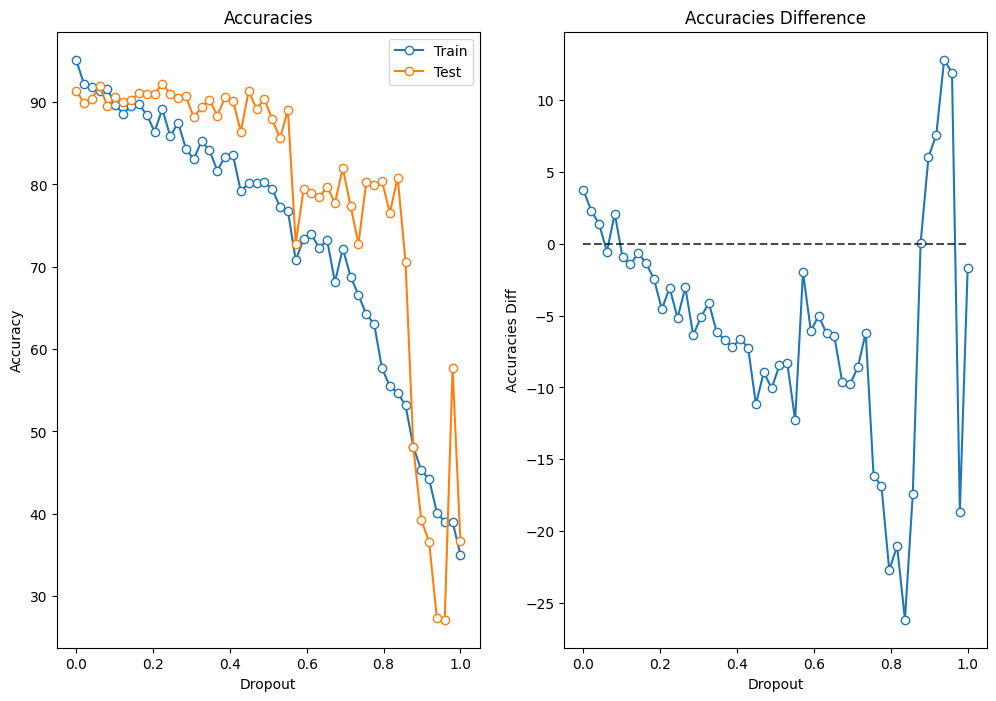

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 8))
ax[0].plot(dropouts, exp_accs, '-o', markerfacecolor='w')
ax[0].set_xlabel('Dropout')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracies')
ax[0].legend(['Train', 'Test'])

ax[1].plot(dropouts, -np.diff(exp_accs), '-o',markerfacecolor='w')
ax[1].plot([0,0], 'k--', alpha=.7)
ax[1].set_xlabel('Dropout')
ax[1].set_ylabel('Accuracies Diff')
ax[1].set_title('Accuracies Difference')

plt.show()

# L1 Regularization

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

## Data

In [4]:
data, labels = sklearn.datasets.load_iris()['data'], sklearn.datasets.load_iris()['target']

data = torch.tensor(data, dtype = torch.float)
labels = torch.tensor(labels, dtype = torch.long)

data[:10], labels[:10]

(tensor([[5.1000, 3.5000, 1.4000, 0.2000],
         [4.9000, 3.0000, 1.4000, 0.2000],
         [4.7000, 3.2000, 1.3000, 0.2000],
         [4.6000, 3.1000, 1.5000, 0.2000],
         [5.0000, 3.6000, 1.4000, 0.2000],
         [5.4000, 3.9000, 1.7000, 0.4000],
         [4.6000, 3.4000, 1.4000, 0.3000],
         [5.0000, 3.4000, 1.5000, 0.2000],
         [4.4000, 2.9000, 1.4000, 0.2000],
         [4.9000, 3.1000, 1.5000, 0.1000]]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## Preprocessing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = X_test.shape[0])

## Model Architecture

In [6]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(4, 64)
    self.hidden = nn.Linear(64,64)
    self.output = nn.Linear(64, 3)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)

    x = self.hidden(x)
    x = F.relu(x)

    x = self.output(x)

    return x

### Test Model

In [7]:
temp_data = torch.randn(100, 4)
temp_ann = ModelArch()
temp_y_hat = temp_ann(temp_data)
temp_y_hat[:20], torch.argmax(temp_y_hat[:20], axis = 1)

(tensor([[ 0.0342,  0.0044,  0.0319],
         [-0.0132, -0.0356, -0.0019],
         [ 0.0091,  0.0532, -0.0258],
         [-0.1054, -0.0225, -0.0234],
         [ 0.0416,  0.0602,  0.0038],
         [-0.0809,  0.0640, -0.0554],
         [-0.0683,  0.0856,  0.1136],
         [-0.0252,  0.1074, -0.0102],
         [-0.0500, -0.0139,  0.0330],
         [-0.2423, -0.1177,  0.0587],
         [ 0.0106,  0.0047,  0.0189],
         [ 0.0076,  0.0901, -0.0277],
         [ 0.0441,  0.0022,  0.0444],
         [ 0.0120, -0.0376,  0.0167],
         [ 0.0690,  0.0395,  0.0371],
         [ 0.0102, -0.0485,  0.0347],
         [ 0.0733,  0.0093, -0.0493],
         [-0.0717,  0.1007,  0.1144],
         [ 0.0470,  0.0819,  0.0101],
         [-0.0300,  0.1540, -0.0253]], grad_fn=<SliceBackward0>),
 tensor([0, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 0, 2, 1, 1]))

## Model Setup

In [8]:
def ModelSetup():
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 0.005)

  return ann, loss_fn, optimizer

## Model Train

We're going to count all weights that don't belong to bias

In [9]:
ann, _, _  = ModelSetup()
weights_cnt = 0
for param_name, weights in ann.named_parameters():
  if 'bias' not in param_name:
    weights_cnt += weights.numel()

weights_cnt

4544

In [10]:
def ModelTrain(l1_lambda, epochs):
  ann, loss_fn, optimizer = ModelSetup()

  train_losses = torch.zeros(epochs)
  train_accs = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  weights_cnt = 0
  for param_name, weights in ann.named_parameters():
    if 'bias' not in param_name:
      weights_cnt += weights.numel()

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      train_y_hat = ann(X_train)
      train_loss = loss_fn(train_y_hat, y_train)
      batch_losses[batch] = train_loss
      batch_acc = 100 * torch.mean(
          (torch.argmax(train_y_hat, axis = 1) == y_train).float()
      )
      batch_accs[batch] = batch_acc

      # L1 Regularization
      l1_term = torch.tensor(0., requires_grad = True)

      for param_name, weights in ann.named_parameters():
        if 'bias' not in param_name:
          l1_term = l1_term + torch.sum(torch.abs(weights))

      train_loss = train_loss + l1_lambda * l1_term / weights_cnt
      ###################

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

    train_losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    ann.eval()

    X_test, y_test = next(iter(test_dataloader))
    test_y_hat = ann(X_test)
    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss
    test_acc = 100 * torch.mean(
        (torch.argmax(test_y_hat, axis = 1) == y_test).float()
    )
    test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Epoch: {epoch} | Train -> Acc: {batch_acc:2f} Loss: {train_loss:2f} | Test -> Acc: {test_acc:2f} Loss: {test_loss:2f}')

  return train_losses, test_losses, train_accs, test_accs

In [11]:
train_losses, test_losses, train_accs, test_accs = ModelTrain(.1, 500)

Epoch: 0 | Train -> Acc: 50.000000 Loss: 1.068631 | Test -> Acc: 36.666668 Loss: 1.219283
Epoch: 10 | Train -> Acc: 83.333328 Loss: 0.918329 | Test -> Acc: 53.333336 Loss: 0.912474
Epoch: 20 | Train -> Acc: 83.333328 Loss: 0.818068 | Test -> Acc: 90.000000 Loss: 0.780562
Epoch: 30 | Train -> Acc: 95.833328 Loss: 0.697866 | Test -> Acc: 96.666664 Loss: 0.673174
Epoch: 40 | Train -> Acc: 91.666672 Loss: 0.668537 | Test -> Acc: 96.666664 Loss: 0.591457
Epoch: 50 | Train -> Acc: 91.666672 Loss: 0.648899 | Test -> Acc: 100.000000 Loss: 0.512921
Epoch: 60 | Train -> Acc: 95.833328 Loss: 0.509593 | Test -> Acc: 100.000000 Loss: 0.468954
Epoch: 70 | Train -> Acc: 91.666672 Loss: 0.448213 | Test -> Acc: 100.000000 Loss: 0.419760
Epoch: 80 | Train -> Acc: 100.000000 Loss: 0.420816 | Test -> Acc: 100.000000 Loss: 0.381510
Epoch: 90 | Train -> Acc: 100.000000 Loss: 0.425846 | Test -> Acc: 100.000000 Loss: 0.362445
Epoch: 100 | Train -> Acc: 95.833328 Loss: 0.483908 | Test -> Acc: 100.000000 Loss: 

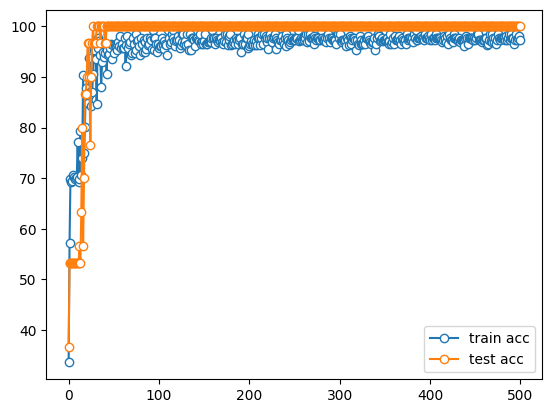

In [12]:
plt.plot(train_accs.detach(), '-o', markerfacecolor='w', label='train acc')
plt.plot(test_accs.detach(), '-o', markerfacecolor='w', label = 'test acc')
plt.legend()

## Experiment

In [13]:
def smooth(x, k = 5):
  return torch.tensor(np.convolve(x, np.ones(k)/k, mode = 'same'), dtype= torch.float)

In [23]:
l1_lambdas = np.linspace(0, .005, 10)
epochs = 1000
train_results = torch.zeros(epochs, len(l1_lambdas))
test_results = torch.zeros(epochs, len(l1_lambdas))


for i in range(len(l1_lambdas)):
  print(f'\n\nPROCESSING: L1 Lambda: {l1_lambdas[i]}')
  train_losses, test_losses, train_accs, test_accs = ModelTrain(l1_lambdas[i], epochs)

  train_results[:, i] = smooth(train_accs.detach(), 10)
  test_results[:, i] = smooth(test_accs.detach(), 10)



PROCESSING: L1 Lambda: 0.0
Epoch: 0 | Train -> Acc: 58.333332 Loss: 1.059073 | Test -> Acc: 83.333328 Loss: 0.946687
Epoch: 10 | Train -> Acc: 83.333328 Loss: 0.873937 | Test -> Acc: 83.333328 Loss: 0.853444
Epoch: 20 | Train -> Acc: 87.500000 Loss: 0.808698 | Test -> Acc: 90.000000 Loss: 0.728219
Epoch: 30 | Train -> Acc: 95.833328 Loss: 0.637158 | Test -> Acc: 96.666664 Loss: 0.619888
Epoch: 40 | Train -> Acc: 70.833328 Loss: 0.693950 | Test -> Acc: 90.000000 Loss: 0.547149
Epoch: 50 | Train -> Acc: 91.666672 Loss: 0.564269 | Test -> Acc: 100.000000 Loss: 0.485719
Epoch: 60 | Train -> Acc: 91.666672 Loss: 0.515813 | Test -> Acc: 100.000000 Loss: 0.447938
Epoch: 70 | Train -> Acc: 100.000000 Loss: 0.450249 | Test -> Acc: 100.000000 Loss: 0.394196
Epoch: 80 | Train -> Acc: 95.833328 Loss: 0.458099 | Test -> Acc: 100.000000 Loss: 0.378884
Epoch: 90 | Train -> Acc: 83.333328 Loss: 0.426494 | Test -> Acc: 100.000000 Loss: 0.351640
Epoch: 100 | Train -> Acc: 95.833328 Loss: 0.408849 | Te

## Plots

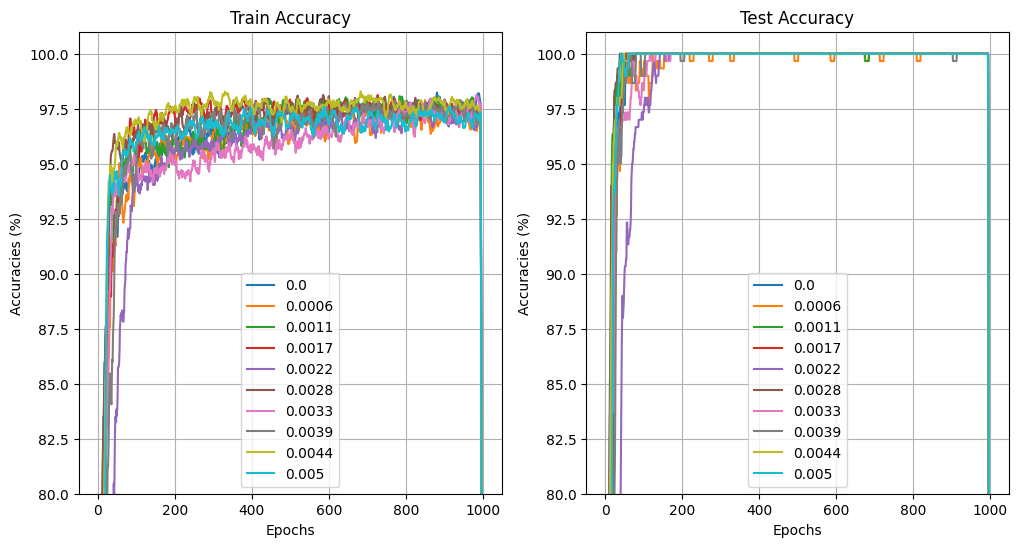

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].plot(train_results)
ax[0].set_title('Train Accuracy')
ax[1].plot(test_results)
ax[1].set_title('Test Accuracy')

l1_labels = [np.round(i, 4) for i in l1_lambdas]

# common features
for i in range(2):
  ax[i].legend(l1_labels)
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Accuracies (%)')
  ax[i].set_ylim([80, 101])
  ax[i].grid()

plt.show()

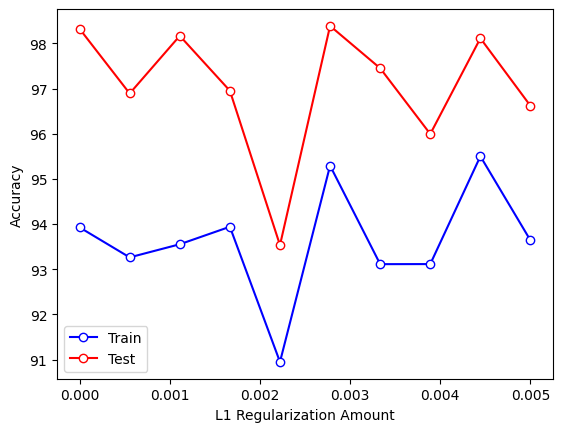

In [28]:
epochs_range = [0, 400]

plt.plot(l1_lambdas,
         torch.mean(train_results[epochs_range[0]:epochs_range[1],:], axis=0),
         'bo-', markerfacecolor = 'w', label = 'Train')

plt.plot(l1_lambdas,
         torch.mean(test_results[epochs_range[0]:epochs_range[1],:], axis=0),
         'ro-', markerfacecolor = 'w', label='Test')

plt.xlabel('L1 Regularization Amount')
plt.ylabel('Accuracy')
plt.legend()

# L2 Regularization

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

## Data

In [ ]:
data, labels = sk.datasets.load_iris()['data'], sk.datasets.load_iris()['target']

data = torch.tensor(data, dtype = torch.float)
labels = torch.tensor(labels, dtype = torch.long)

## Preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = X_test.shape[0])

## Model Arch

In [ ]:
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(4, 128)
    self.hidden = nn.Linear(128, 128)
    self.output = nn.Linear(128, 3)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)

    x = self.hidden(x)
    x = F.relu(x)

    x = self.output(x)

    return x

## Model Setup

In [ ]:
def ModelSetup(L2_lambda):
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 1e-3, weight_decay = L2_lambda)

  return ann, loss_fn, optimizer

## Model Train

In [ ]:
def train(L2_lambda, epochs):
  ann, loss_fn, optimizer = ModelSetup(L2_lambda)

  train_losses = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)

  train_accs = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):
      batch_y_hat = ann(X_train)

      batch_loss = loss_fn(batch_y_hat, y_train)
      batch_losses[batch] = batch_loss

      batch_acc = 100 * torch.mean(
          (torch.argmax(batch_y_hat, axis = 1) == y_train).float()
      )
      batch_accs[batch] = batch_acc

      optimizer.zero_grad()
      batch_loss.backward()
      optimizer.step()

    train_losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    ann.eval()

    X_test, y_test = next(iter(test_dataloader))
    test_y_hat = ann(X_test)

    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss

    test_acc = 100 * torch.mean(
          (torch.argmax(test_y_hat, axis = 1) == y_test).float()
      )
    test_accs[epoch] = test_acc

    if epoch % 10 == 0:
      print(f'Ep: {epoch} | Train -> Loss: {batch_loss:2f}, Acc: {batch_acc:2f} | Test -> Loss: {test_loss:2f}, Acc: {test_acc:2f}')

  return train_losses, train_accs, test_losses, test_accs

In [ ]:
train_losses, train_accs, test_losses, test_accs = train(0.2, 1000)

Ep: 0 | Train -> Loss: 1.110583, Acc: 29.166666 | Test -> Loss: 1.126878, Acc: 30.000002
Ep: 10 | Train -> Loss: 1.026702, Acc: 58.333332 | Test -> Loss: 1.027345, Acc: 46.666668
Ep: 20 | Train -> Loss: 0.993899, Acc: 54.166668 | Test -> Loss: 0.989995, Acc: 70.000000
Ep: 30 | Train -> Loss: 0.970510, Acc: 62.500000 | Test -> Loss: 0.960321, Acc: 73.333336
Ep: 40 | Train -> Loss: 0.933224, Acc: 79.166672 | Test -> Loss: 0.932627, Acc: 70.000000
Ep: 50 | Train -> Loss: 0.898431, Acc: 87.500000 | Test -> Loss: 0.909767, Acc: 73.333336
Ep: 60 | Train -> Loss: 0.866199, Acc: 75.000000 | Test -> Loss: 0.886599, Acc: 73.333336
Ep: 70 | Train -> Loss: 0.857251, Acc: 70.833328 | Test -> Loss: 0.863971, Acc: 73.333336
Ep: 80 | Train -> Loss: 0.838075, Acc: 75.000000 | Test -> Loss: 0.843699, Acc: 86.666664
Ep: 90 | Train -> Loss: 0.829125, Acc: 62.500000 | Test -> Loss: 0.822596, Acc: 80.000000
Ep: 100 | Train -> Loss: 0.830426, Acc: 58.333332 | Test -> Loss: 0.804907, Acc: 80.000000
Ep: 110 | 

## Experiment

### Smoothing (Side Note)

In [ ]:
def smooth(x, k = 5):
  return torch.tensor(np.convolve(x, np.ones(k)/k, mode = 'same'), dtype= torch.float)

In [ ]:
np.ones(10)/10

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

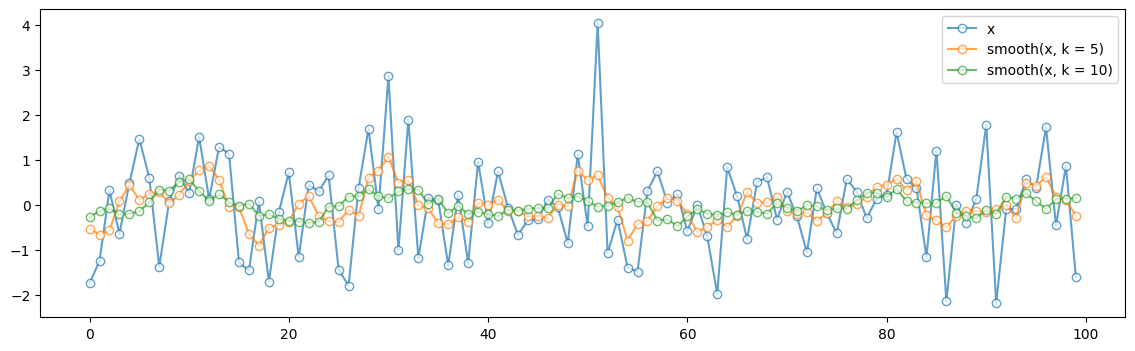

In [ ]:
x = np.random.randn(100)

fig = plt.figure(figsize = (14, 4))
plt.plot(x, '-o', markerfacecolor = 'w', alpha = .7)
plt.plot(smooth(x, 5), '-o', markerfacecolor = 'w', alpha = .7)
plt.plot(smooth(x, 10), '-o', markerfacecolor = 'w', alpha = .7)
plt.legend(['x', 'smooth(x, k = 5)', 'smooth(x, k = 10)'])

plt.show()

### Run

In [ ]:
l2_lambdas = np.linspace(0, .1, 10)
epochs = 1000
train_results = torch.zeros(epochs, len(l2_lambdas))
test_results = torch.zeros(epochs, len(l2_lambdas))


for i in range(len(l2_lambdas)):
  print(f'\n\nPROCESSING: L2 Lambda: {l2_lambdas[i]}')
  train_losses, train_accs, test_losses, test_accs = train(l2_lambdas[i], epochs)

  train_results[:, i] = smooth(train_accs, 10)
  test_results[:, i] = smooth(test_accs, 10)



PROCESSING: L2 Lambda: 0.0
Ep: 0 | Train -> Loss: 1.256740, Acc: 29.166666 | Test -> Loss: 1.290600, Acc: 30.000002
Ep: 10 | Train -> Loss: 1.099536, Acc: 41.666664 | Test -> Loss: 1.109114, Acc: 30.000002
Ep: 20 | Train -> Loss: 1.082022, Acc: 20.833332 | Test -> Loss: 1.047307, Acc: 40.000000
Ep: 30 | Train -> Loss: 1.021635, Acc: 45.833336 | Test -> Loss: 1.004214, Acc: 40.000000
Ep: 40 | Train -> Loss: 0.960823, Acc: 79.166672 | Test -> Loss: 0.968729, Acc: 70.000000
Ep: 50 | Train -> Loss: 0.935182, Acc: 66.666672 | Test -> Loss: 0.934907, Acc: 70.000000
Ep: 60 | Train -> Loss: 0.920025, Acc: 62.500000 | Test -> Loss: 0.903277, Acc: 73.333336
Ep: 70 | Train -> Loss: 0.849459, Acc: 79.166672 | Test -> Loss: 0.870494, Acc: 76.666664
Ep: 80 | Train -> Loss: 0.830677, Acc: 83.333328 | Test -> Loss: 0.838792, Acc: 76.666664
Ep: 90 | Train -> Loss: 0.810135, Acc: 70.833328 | Test -> Loss: 0.807480, Acc: 76.666664
Ep: 100 | Train -> Loss: 0.792571, Acc: 62.500000 | Test -> Loss: 0.7784

### Plots

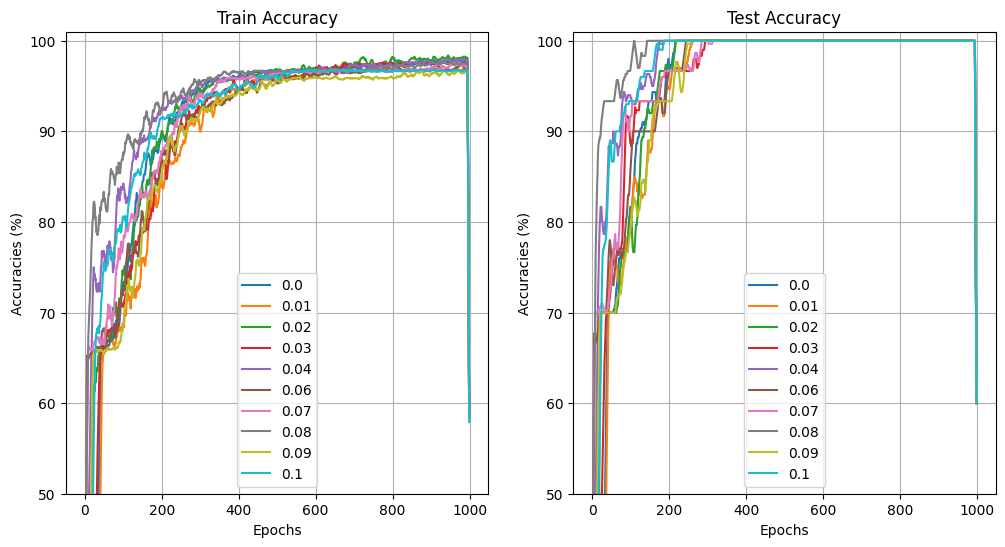

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))

ax[0].plot(train_results)
ax[0].set_title('Train Accuracy')
ax[1].plot(test_results)
ax[1].set_title('Test Accuracy')

l2_labels = [np.round(i, 2) for i in l2_lambdas]

# common features
for i in range(2):
  ax[i].legend(l2_labels)
  ax[i].set_xlabel('Epochs')
  ax[i].set_ylabel('Accuracies (%)')
  ax[i].set_ylim([50, 101])
  ax[i].grid()

plt.show()

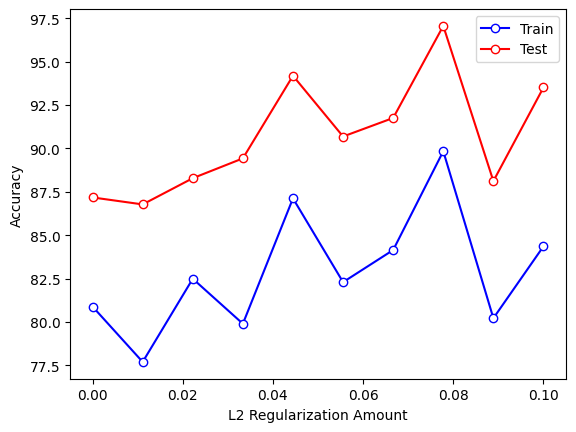

In [ ]:
epochs_range = [0, 400]

plt.plot(l2_lambdas,
         torch.mean(train_results[epochs_range[0]:epochs_range[1],:], axis=0),
         'bo-', markerfacecolor = 'w', label = 'Train')

plt.plot(l2_lambdas,
         torch.mean(test_results[epochs_range[0]:epochs_range[1],:], axis=0),
         'ro-', markerfacecolor = 'w', label='Test')

plt.xlabel('L2 Regularization Amount')
plt.ylabel('Accuracy')
plt.legend()

# L1 + L2 (elastic net reg)

## Code

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

Epoch: 0 | Train -> Acc: 41.666664 Loss: 1.059052 | Test -> Acc: 43.333332 Loss: 1.098454
Epoch: 10 | Train -> Acc: 41.666664 Loss: 0.961297 | Test -> Acc: 20.000000 Loss: 1.060192
Epoch: 20 | Train -> Acc: 70.833328 Loss: 0.815399 | Test -> Acc: 43.333332 Loss: 0.991134
Epoch: 30 | Train -> Acc: 66.666672 Loss: 0.758302 | Test -> Acc: 43.333332 Loss: 0.903172
Epoch: 40 | Train -> Acc: 91.666672 Loss: 0.541304 | Test -> Acc: 43.333332 Loss: 0.838516
Epoch: 50 | Train -> Acc: 87.500000 Loss: 0.507367 | Test -> Acc: 43.333332 Loss: 0.769224
Epoch: 60 | Train -> Acc: 87.500000 Loss: 0.457553 | Test -> Acc: 43.333332 Loss: 0.709201
Epoch: 70 | Train -> Acc: 79.166672 Loss: 0.469721 | Test -> Acc: 46.666668 Loss: 0.660172
Epoch: 80 | Train -> Acc: 62.500000 Loss: 0.518135 | Test -> Acc: 53.333336 Loss: 0.594691
Epoch: 90 | Train -> Acc: 62.500000 Loss: 0.518241 | Test -> Acc: 63.333332 Loss: 0.560131
Epoch: 100 | Train -> Acc: 95.833328 Loss: 0.396917 | Test -> Acc: 63.333332 Loss: 0.539340

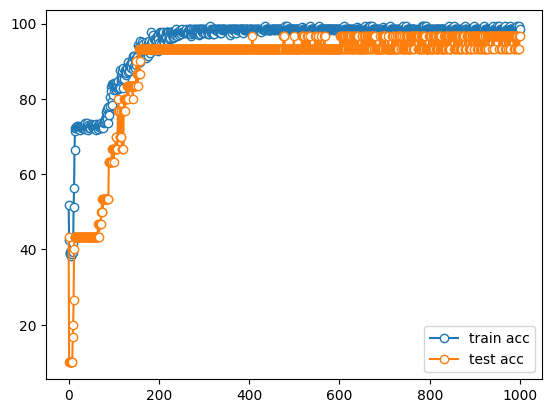

In [11]:
### DATA
data, labels = sklearn.datasets.load_iris()['data'], sklearn.datasets.load_iris()['target']

data = torch.tensor(data, dtype = torch.float)
labels = torch.tensor(labels, dtype = torch.long)

### PREPROCESSING
X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size = 0.8)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = X_test.shape[0])

### MODEL ARCH
class ModelArch(nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(4, 64)
    self.hidden = nn.Linear(64,64)
    self.output = nn.Linear(64, 3)

  def forward(self, x):
    x = self.input(x)
    x = F.relu(x)

    x = self.hidden(x)
    x = F.relu(x)

    x = self.output(x)

    return x

### MODEL SETUP
def ModelSetup():
  ann = ModelArch()
  loss_fn = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(ann.parameters(), lr = 0.005)

  return ann, loss_fn, optimizer

### MODEL TRAIN
def ModelTrain(l1_lambda, l2_lambda, epochs):
  ann, loss_fn, optimizer = ModelSetup()

  train_losses = torch.zeros(epochs)
  train_accs = torch.zeros(epochs)
  test_losses = torch.zeros(epochs)
  test_accs = torch.zeros(epochs)

  weights_cnt = 0
  for param_name, weights in ann.named_parameters():
    if 'bias' not in param_name:
      weights_cnt += weights.numel()

  for epoch in range(epochs):
    ann.train()

    batch_losses = torch.zeros(len(train_dataloader))
    batch_accs = torch.zeros(len(train_dataloader))

    for batch, (X_train, y_train) in enumerate(train_dataloader):

      train_y_hat = ann(X_train)
      train_loss = loss_fn(train_y_hat, y_train)
      batch_losses[batch] = train_loss
      batch_acc = 100 * torch.mean(
          (torch.argmax(train_y_hat, axis = 1) == y_train).float()
      )
      batch_accs[batch] = batch_acc

      # L1 and L2 Manual Regularization
      l1_term = torch.tensor(0., requires_grad = True)
      l2_term = torch.tensor(0., requires_grad = True)

      for param_name, weights in ann.named_parameters():
        if 'bias' not in param_name:
          l1_term = l1_term + torch.sum(torch.abs(weights))
          l2_term = l2_term + torch.sum(weights**2)


      l1 = l1_lambda * l1_term / weights_cnt
      l2 = l2_lambda * l2_term / weights_cnt

      train_loss = train_loss + l1 + l2
      ###################

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()

    train_losses[epoch] = torch.mean(batch_losses)
    train_accs[epoch] = torch.mean(batch_accs)

    ann.eval()

    X_test, y_test = next(iter(test_dataloader))
    test_y_hat = ann(X_test)
    test_loss = loss_fn(test_y_hat, y_test)
    test_losses[epoch] = test_loss
    test_acc = 100 * torch.mean(
        (torch.argmax(test_y_hat, axis = 1) == y_test).float()
    )
    test_accs[epoch] = test_acc

    if epoch%10 == 0:
      print(f'Epoch: {epoch} | Train -> Acc: {batch_acc:2f} Loss: {train_loss:2f} | Test -> Acc: {test_acc:2f} Loss: {test_loss:2f}')

  return train_losses, test_losses, train_accs, test_accs

train_losses, test_losses, train_accs, test_accs = ModelTrain(l1_lambda = 0.005, l2_lambda = 0.1, epochs = 1000)

### PLOT SINGLE TRAIN
plt.plot(train_accs.detach(), '-o', markerfacecolor='w', label='train acc')
plt.plot(test_accs.detach(), '-o', markerfacecolor='w', label = 'test acc')
plt.legend()

## Experiment

In [14]:
import numpy as np
import plotly.graph_objects as go

# zakres testowanych lambd
l1_values = np.array([0.0, 0.001, 0.01, 0.05, 0.1])
l2_values = np.array([0.0, 0.001, 0.01, 0.05, 0.1])

acc_matrix = []

for l1 in l1_values:
    row = []
    for l2 in l2_values:
        train_losses, test_losses, train_accs, test_accs = ModelTrain(l1_lambda=l1,
                                                                      l2_lambda=l2,
                                                                      epochs=200)
        row.append(test_accs[-1].item())
    acc_matrix.append(row)

acc_matrix = np.array(acc_matrix)

# siatka
L1, L2 = np.meshgrid(l1_values, l2_values)


Epoch: 0 | Train -> Acc: 37.500000 Loss: 1.169668 | Test -> Acc: 33.333336 Loss: 1.258862
Epoch: 10 | Train -> Acc: 41.666664 Loss: 0.976988 | Test -> Acc: 10.000000 Loss: 1.163720
Epoch: 20 | Train -> Acc: 58.333332 Loss: 0.958245 | Test -> Acc: 40.000000 Loss: 1.099835
Epoch: 30 | Train -> Acc: 75.000000 Loss: 0.836212 | Test -> Acc: 43.333332 Loss: 1.034611
Epoch: 40 | Train -> Acc: 75.000000 Loss: 0.742971 | Test -> Acc: 43.333332 Loss: 0.954102
Epoch: 50 | Train -> Acc: 79.166672 Loss: 0.648563 | Test -> Acc: 43.333332 Loss: 0.878132
Epoch: 60 | Train -> Acc: 66.666672 Loss: 0.665104 | Test -> Acc: 43.333332 Loss: 0.791525
Epoch: 70 | Train -> Acc: 58.333332 Loss: 0.668504 | Test -> Acc: 43.333332 Loss: 0.721742
Epoch: 80 | Train -> Acc: 75.000000 Loss: 0.483047 | Test -> Acc: 46.666668 Loss: 0.674039
Epoch: 90 | Train -> Acc: 66.666672 Loss: 0.481181 | Test -> Acc: 50.000000 Loss: 0.621007
Epoch: 100 | Train -> Acc: 91.666672 Loss: 0.312524 | Test -> Acc: 50.000000 Loss: 0.589145

In [15]:
# wykres 3D w Plotly
fig = go.Figure(data=[go.Surface(
    x=L1, y=L2, z=acc_matrix.T,
    colorscale="Viridis", opacity=0.9
)])

fig.update_layout(
    scene=dict(
        xaxis_title="L1 λ",
        yaxis_title="L2 λ",
        zaxis_title="Test Accuracy (%)"
    ),
    title="Accuracy Landscape (L1 vs L2)",
    width=900, height=700,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()